# Start-up

In this notebook, we provide an overview of publication medatata and create the data frames for further analyses.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set(style="white")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [2]:
# load publication metadata

df_meta = pd.read_csv("../cwts_covid/datasets_output/df_pub.csv",compression="gzip")

In [3]:
df_meta.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,arxiv_id,timestamp
0,0,Coronavirus disease 2019 (COVID-19) and simult...,Coronavirus disease 2019 (COVID-19) is a recen...,2020.0,5.0,CardioVascular Journal of Africa,31,NaN,1-4,10-5830-cvja-2020-016,32490506.0,NaN,pub.1128171889,NaN,2020-07-02 10:54:27.347501
1,1,[Ten hot issues of breast cancer under the nov...,NaN,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,32036640.0,NaN,pub.1124777091,NaN,2020-07-02 10:54:27.347501
2,2,Cohesion in Distancing.,"In isolation, we are physically apart; in soli...",2020.0,4.0,The AMA Journal of Ethic,22,4,e344-345,10.1001/amajethics.2020.344,32345430.0,NaN,pub.1127182341,NaN,2020-07-02 10:54:27.347501
3,3,Salvation in a Time of Plague.,Health workers offer their skills and care to ...,2020.0,5.0,The AMA Journal of Ethic,22,5,e441-445,10.1001/amajethics.2020.441,32449663.0,NaN,pub.1127905371,NaN,2020-07-02 10:54:27.347501
4,4,What Should Health Science Journalists Do in E...,Journalists have long covered outbreaks of inf...,2020.0,1.0,AMA journal of ethics,NaN,NaN,NaN,10.1001/amajethics.2020.55,31958392.0,NaN,NaN,NaN,2020-07-02 10:54:27.347501


In [4]:
df_meta.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'arxiv_id', 'timestamp'],
      dtype='object')

In [5]:
df_meta.shape

(160656, 15)

#### Publication years

In [6]:
import re

def clean_year(s):
    if pd.isna(s):
        return np.nan
    if not (s>1900):
        return np.nan
    elif s>2020:
        return 2020
    return s

df_meta["publication_year"] = df_meta["publication_year"].apply(clean_year)

In [7]:
df_meta.publication_year.describe()

count    160644.000000
mean       2015.180822
std           7.054152
min        1901.000000
25%        2012.000000
50%        2018.000000
75%        2020.000000
max        2020.000000
Name: publication_year, dtype: float64

In [128]:
df_meta[df_meta.publication_year>2019].shape

(72795, 16)

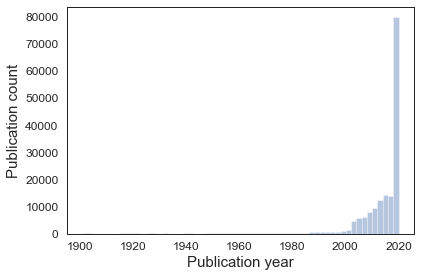

In [110]:
b = sns.distplot(df_meta.publication_year, bins=60, kde=False)
b.set_xlabel("Publication year",fontsize=15)
b.set_ylabel("Publication count",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/meta_pub_year_all.pdf")

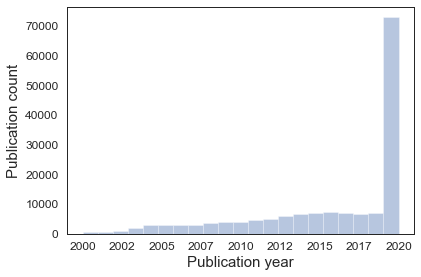

In [111]:
b = sns.distplot([int(y) for y in df_meta[df_meta.publication_year>1999].publication_year.tolist() if y], bins=21, kde=False)
b.set_xlabel("Publication year",fontsize=15)
b.set_ylabel("Publication count",fontsize=15)
b.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
plt.savefig("figures/meta_pub_year_2000.pdf")

#### Detect language

In [10]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = seed

In [11]:
df_meta["title"] = df_meta["title"].fillna('')
df_meta["abstract"] = df_meta["abstract"].fillna('')
df_meta["title_abstract"] = df_meta.title +" "+df_meta.abstract

In [12]:
df_meta["lang"] = None

In [13]:
def detect_lang(txt):
    try:
        return detect(txt)
    except:
        return None

In [14]:
%%time

df_meta["lang"] = df_meta["title_abstract"].apply(detect_lang)

CPU times: user 19min 9s, sys: 25.3 s, total: 19min 34s
Wall time: 19min 42s


In [15]:
df_meta.drop(columns="title_abstract", inplace=True)

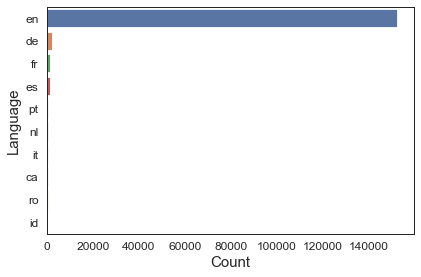

In [16]:
# languages

df_sub = df_meta[df_meta.lang.isin(df_meta.lang.value_counts()[:10].index.tolist())]
b = sns.countplot(y="lang", data=df_sub, order=df_sub['lang'].value_counts().index)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Count",fontsize=15)
b.set_ylabel("Language",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/meta_lang.pdf")

## Dimensions

In [17]:
# load Dimensions data (you will need to download it on your own)

directory_name = "../cwts_covid/datasets_output/json_dimensions_cwts"

all_dimensions = list()
for root, dirs, files in os.walk(directory_name):
    for file in files:
        if ".json" in file:
            all_data = codecs.open(os.path.join(root,file)).read()
            for record in all_data.split("\n"):
                if record:
                    all_dimensions.append(json.loads(record))

In [18]:
#all_dimensions[0]

In [19]:
df_dimensions = pd.DataFrame.from_dict({
    "id":[r["id"] for r in all_dimensions],
    "altmetric_id":[r["altmetric_id"] for r in all_dimensions],
    "year":[r["year"] for r in all_dimensions],
    "month":[int(r["publication_date"][5:7]) for r in all_dimensions],
    "publication_date":[r["publication_date"] for r in all_dimensions],
    "publication_type":[r["publication_type"] for r in all_dimensions],
    "doi":[r["doi"] for r in all_dimensions],
    "pmid":[r["pmid"] for r in all_dimensions],
    "issn":[r["journal"]["issn"] for r in all_dimensions],
    "times_cited":[r["times_cited"] for r in all_dimensions],
    "relative_citation_ratio":[r["relative_citation_ratio"] for r in all_dimensions],
    "for_top":[r["for"][0]["first_level"]["name"] if len(r["for"])>0 else "" for r in all_dimensions],
    "for_bottom":[r["for"][0]["second_level"]["name"] if len(r["for"])>0 else "" for r in all_dimensions]
})

In [20]:
df_dimensions.head()

,id,altmetric_id,year,month,publication_date,publication_type,doi,pmid,issn,times_cited,relative_citation_ratio,for_top,for_bottom
0,pub.1127982992,83013868.0,2020,5,2020-05-01,article,10.1053/j.gastro.2020.05.066,32479824,0016-5085,0,NaN,,
1,pub.1127467922,0.0,2020,5,2020-05-01,article,10.1053/j.jvca.2020.04.061,32507459,1053-0770,0,NaN,,
2,pub.1127651503,82256754.0,2020,5,2020-05-01,article,10.1053/j.gastro.2020.05.037,32425228,0016-5085,0,NaN,,
3,pub.1127316115,0.0,2020,5,2020-05-01,article,10.1053/j.gastro.2020.04.061,32371115,0016-5085,0,NaN,,
4,pub.1127684826,82268373.0,2020,5,2020-05-01,article,10.1053/j.gastro.2020.05.032,32425234,0016-5085,7,NaN,Medical and Health Sciences,Clinical Sciences


In [21]:
df_dimensions.dtypes

id                          object
altmetric_id               float64
year                         int64
month                        int64
publication_date            object
publication_type            object
doi                         object
pmid                        object
issn                        object
times_cited                  int64
relative_citation_ratio    float64
for_top                     object
for_bottom                  object
dtype: object

In [22]:
# We only focus on publications with DOI or PMID since Altmetrics data is limited to those
# to check:
# df_dimensions[pd.isnull(df_dimensions.doi) & pd.isnull(df_dimensions.pmid) & pd.notnull(df_dimensions.altmetric_id)]

In [23]:
df_dimensions.pmid = df_dimensions.pmid.astype(float)

In [24]:
df_dimensions.shape

(150749, 13)

In [25]:
df_joined_doi = df_meta[pd.notnull(df_meta.doi)].merge(df_dimensions[pd.notnull(df_dimensions.doi)], how="inner", suffixes=('','_y'), left_on="doi", right_on="doi", copy=False)

In [26]:
df_joined_doi.shape

(138290, 28)

In [27]:
df_joined_pmid = df_meta[pd.isnull(df_meta.doi) & pd.notnull(df_meta.pmid)].merge(df_dimensions[pd.isnull(df_dimensions.doi) & pd.notnull(df_dimensions.pmid)], how="inner", suffixes=('','_y'), left_on="pmid", right_on="pmid", copy=False)

In [28]:
df_joined_pmid.shape

(3493, 28)

In [29]:
df_joined = pd.concat([df_joined_doi,df_joined_pmid])
df_joined = df_joined[df_joined.columns.drop(["doi_y","pmid_y"])]

In [30]:
df_joined.head()

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,...,altmetric_id,year,month,publication_date,publication_type,issn,times_cited,relative_citation_ratio,for_top,for_bottom
0,0,Coronavirus disease 2019 (COVID-19) and simult...,Coronavirus disease 2019 (COVID-19) is a recen...,2020.0,5.0,CardioVascular Journal of Africa,31,NaN,1-4,10-5830-cvja-2020-016,...,0.0,2020,5,2020-05-05,article,1995-1892,0,NaN,Medical and Health Sciences,Cardiorespiratory Medicine and Haematology
1,0,Coronavirus disease 2019 (COVID-19) and simult...,Coronavirus disease 2019 (COVID-19) is a recen...,2020.0,5.0,CardioVascular Journal of Africa,31,NaN,1-4,10-5830-cvja-2020-016,...,0.0,2020,5,2020-05-05,article,1995-1892,0,NaN,Medical and Health Sciences,Cardiorespiratory Medicine and Haematology
2,1,[Ten hot issues of breast cancer under the nov...,,2020.0,2.0,Chinese medical journal,100,0,e002,10.0376/cma.j.issn.0376-2491.2020.0002,...,75778970.0,2020,2,2020-02-10,article,0376-2491,0,NaN,,
3,2,Cohesion in Distancing.,"In isolation, we are physically apart; in soli...",2020.0,4.0,The AMA Journal of Ethic,22,4,e344-345,10.1001/amajethics.2020.344,...,78676044.0,2020,4,2020-04-01,article,2376-6980,1,NaN,,
4,3,Salvation in a Time of Plague.,Health workers offer their skills and care to ...,2020.0,5.0,The AMA Journal of Ethic,22,5,e441-445,10.1001/amajethics.2020.441,...,80348292.0,2020,5,2020-05-01,article,2376-6980,0,NaN,Medical and Health Sciences,Public Health and Health Services


In [31]:
df_joined.shape

(141783, 27)

In [32]:
df_joined = df_joined.groupby("pub_id").first().reset_index()

In [33]:
df_joined[df_joined.pub_id==29534]

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,...,altmetric_id,year,month,publication_date,publication_type,issn,times_cited,relative_citation_ratio,for_top,for_bottom
28533,29534,Chapter 11 Detection of Analytes on Arrays/Mic...,Publisher Summary Microarrays/arrays/DNA chips...,2011.0,12.0,Handbook of Biosensors and Biosensor Kinetics,NaN,NaN,NaN,10.1016/b978-0-444-53262-6.00011-5,...,0.0,2011,1,2011-01-01,chapter,None,0,NaN,Chemical Sciences,Physical Chemistry (incl. Structural)


In [34]:
# Most publications are in Dimensions via DOI or PMID: we focus on these

In [35]:
df_joined.shape

(141224, 27)

In [36]:
df_meta.shape

(160656, 16)

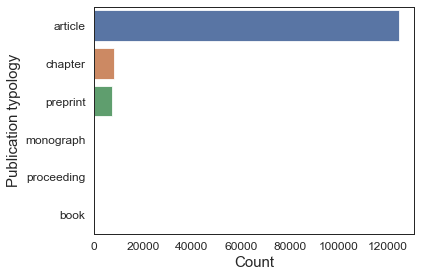

In [37]:
# publication typology

df_sub = df_joined[df_joined.publication_type.isin(df_joined.publication_type.value_counts()[:10].index.tolist())]
b = sns.countplot(y="publication_type", data=df_sub, order=df_sub['publication_type'].value_counts().index)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Count",fontsize=15)
b.set_ylabel("Publication typology",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/dim_pub_type.pdf")

#### Citation counts

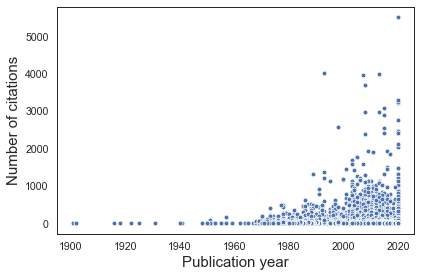

In [112]:
# scatter of citations vs time of publication

sns.scatterplot(df_joined.publication_year.to_list(),df_joined.times_cited.to_list())
plt.xlabel("Publication year", fontsize=15)
plt.ylabel("Number of citations", fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/dim_citations_year.pdf")

In [40]:
# most cited papers

df_joined[["title","times_cited","relative_citation_ratio","journal","publication_year","doi"]].sort_values("times_cited",ascending=False).head(10)

,title,times_cited,relative_citation_ratio,journal,publication_year,doi
56043,Clinical features of patients infected with 20...,5508,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30183-5
74499,Biological roles of oligosaccharides: all of t...,4021,92.34,Glycobiology,1993.0,10.1093/glycob/3.2.97
77301,Surviving sepsis campaign: international guide...,3998,205.11,Critical care medicine,2013.0,10.1097/ccm.0b013e31827e83af
72001,Infectious Diseases Society of America/America...,3967,111.15,Clin Infect Dis,2007.0,10.1086/511159
55735,Epidemiology and causes of preterm birth,3680,120.06,The Lancet,2008.0,10.1016/s0140-6736(08)60074-4
68485,Clinical Characteristics of Coronavirus Diseas...,3278,NaN,New England Journal of Medicine,2020.0,10.1056/nejmoa2002032
68481,A Novel Coronavirus from Patients with Pneumon...,3250,NaN,New England Journal of Medicine,2020.0,10.1056/nejmoa2001017
277,Clinical Characteristics of 138 Hospitalized P...,3220,NaN,JAMA,2020.0,10.1001/jama.2020.1585
68466,Randomized assessment of rapid endovascular tr...,3079,197.01,The New England journal of medicine,2015.0,10.1056/nejmoa1414905
13119,Surviving Sepsis Campaign: International Guide...,2962,147.71,Intensive Care Med,2013.0,10.1007/s00134-012-2769-8


In [41]:
# same but in 2020; note that duplicates are due to SI or pre-prints with different PMIDs

df_joined[df_joined.publication_year>2019][["title","times_cited","relative_citation_ratio","journal","publication_year","doi"]].sort_values("times_cited",ascending=False).head(10)

,title,times_cited,relative_citation_ratio,journal,publication_year,doi
56043,Clinical features of patients infected with 20...,5508,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30183-5
68485,Clinical Characteristics of Coronavirus Diseas...,3278,NaN,New England Journal of Medicine,2020.0,10.1056/nejmoa2002032
68481,A Novel Coronavirus from Patients with Pneumon...,3250,NaN,New England Journal of Medicine,2020.0,10.1056/nejmoa2001017
277,Clinical Characteristics of 138 Hospitalized P...,3220,NaN,JAMA,2020.0,10.1001/jama.2020.1585
56047,Epidemiological and clinical characteristics o...,2762,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30211-7
56120,Clinical course and risk factors for mortality...,2464,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30566-3
68484,"Early Transmission Dynamics in Wuhan, China, o...",2399,NaN,New England Journal of Medicine,2020.0,10.1056/nejmoa2001316
65299,A pneumonia outbreak associated with a new cor...,2115,NaN,Nature,2020.0,10.1038/s41586-020-2012-7
295,Characteristics of and Important Lessons From ...,2042,NaN,JAMA,2020.0,10.1001/jama.2020.2648
56037,A familial cluster of pneumonia associated wit...,1485,NaN,The Lancet,2020.0,10.1016/s0140-6736(20)30154-9


In [42]:
# most cited journals

df_joined[['journal','times_cited']].groupby('journal').sum().sort_values('times_cited',ascending=False).head(10)

,times_cited
journal,
The Lancet,51215
PLoS One,40269
Nature,39599
Virology,36643
Emerg Infect Dis,35280
Journal of virology,33933
JAMA,28512
Surgical endoscopy,23332
Lancet,22943


## Altmetrics

In [43]:
# load Altmetrics data (you will need to download it on your own)

directory_name = "../cwts_covid/datasets_output/json_altmetrics_cwts"

all_altmetrics = list()
for root, dirs, files in os.walk(directory_name):
    for file in files:
        if ".json" in file:
            all_altmetrics.append(json.loads(codecs.open(os.path.join(root,file)).read()))

In [44]:
#all_altmetrics[1]

In [45]:
len(all_altmetrics)

101662

In [46]:
df_altmetrics = pd.DataFrame.from_dict({
    "altmetric_id":[r["altmetric_id"] if "altmetric_id" in r.keys() else None for r in all_altmetrics],
    "counts_mendeley":[r["counts"]["readers"]["mendeley"] if "readers" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_news":[r["counts"]["news"]["posts_count"] if "news" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_blogs":[r["counts"]["blogs"]["posts_count"] if "blogs" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_facebook":[r["counts"]["facebook"]["posts_count"] if "facebook" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_policy":[r["counts"]["policy"]["posts_count"] if "policy" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_wikipedia":[r["counts"]["wikipedia"]["posts_count"] if "wikipedia" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_twitter_count":[r["counts"]["twitter"]["posts_count"] if "twitter" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_twitter_unique":[r["counts"]["twitter"]["unique_users_count"] if "twitter" in r["counts"].keys() else 0 for r in all_altmetrics],
    "counts_total":[r["counts"]["total"]["posts_count"] if "total" in r["counts"].keys() else 0 for r in all_altmetrics],
    "doi":[r["citation"]["doi"] if "doi" in r["citation"] else None for r in all_altmetrics],
    "pmid":[r["citation"]["pmid"] if "pmid" in r["citation"] else None for r in all_altmetrics],
    "year":[int(r["citation"]["pubdate"][:4]) if "pubdate" in r["citation"] else None for r in all_altmetrics],
    "title":[r["citation"]["title"] if "title" in r["citation"] else None for r in all_altmetrics],
    #"abstract":[r["citation"]["abstract"] if "abstract" in r["citation"] else None for r in all_altmetrics],
    "altmetric_score":[r["altmetric_score"]["score"] for r in all_altmetrics],
    "member_of_the_public":[r["demographics"]["poster_types"]["member_of_the_public"] if "demographics" in r.keys() and isinstance(r["demographics"],dict) and "poster_types" in r["demographics"].keys() and "member_of_the_public" in r["demographics"]["poster_types"].keys() else 0 for r in all_altmetrics],
    "researcher":[r["demographics"]["poster_types"]["researcher"] if "demographics" in r.keys() and isinstance(r["demographics"],dict) and "poster_types" in r["demographics"].keys() and "researcher" in r["demographics"]["poster_types"].keys() else 0 for r in all_altmetrics],
    "practitioner":[r["demographics"]["poster_types"]["practitioner"] if "demographics" in r.keys() and isinstance(r["demographics"],dict) and "poster_types" in r["demographics"].keys() and "practitioner" in r["demographics"]["poster_types"].keys() else 0 for r in all_altmetrics],
    "science_communicator":[r["demographics"]["poster_types"]["science_communicator"] if "demographics" in r.keys() and isinstance(r["demographics"],dict) and "poster_types" in r["demographics"].keys() and "science_communicator" in r["demographics"]["poster_types"].keys() else 0 for r in all_altmetrics]
})

In [47]:
df_altmetrics.shape

(101662, 19)

In [48]:
df_altmetrics['counts_mendeley'] = df_altmetrics['counts_mendeley'].astype(float)

In [49]:
# aggregate possible duplicates by summing their values up
# this is the recommended approach by Altmetric

df_altmetrics_aggr = df_altmetrics[['altmetric_id', 'counts_mendeley', 'counts_news', 'counts_blogs',
       'counts_facebook', 'counts_policy', 'counts_wikipedia',
       'counts_twitter_count', 'counts_twitter_unique', 'counts_total', 'altmetric_score', 'member_of_the_public',
       'researcher', 'practitioner', 'science_communicator']].groupby("altmetric_id").agg('sum')

In [50]:
df_altmetrics = df_altmetrics[['altmetric_id', 'doi',
       'pmid', 'year', 'title']].merge(df_altmetrics_aggr, how="inner", left_on="altmetric_id", right_on="altmetric_id")

In [51]:
df_altmetrics.drop_duplicates('altmetric_id',inplace=True)

In [52]:
df_altmetrics.shape

(94600, 19)

In [53]:
df_altmetrics[df_altmetrics.doi=="10.1086/511159"]

,altmetric_id,doi,pmid,year,title,counts_mendeley,counts_news,counts_blogs,counts_facebook,counts_policy,counts_wikipedia,counts_twitter_count,counts_twitter_unique,counts_total,altmetric_score,member_of_the_public,researcher,practitioner,science_communicator
66870,390412.0,10.1086/511159,17278083,2007.0,Infectious Diseases Society of America/America...,3592.0,12,16,2,4,8,52,48,95,140.344,35,2,11,0


In [54]:
#all_altmetrics[26239]

In [55]:
df_altmetrics.head()

,altmetric_id,doi,pmid,year,title,counts_mendeley,counts_news,counts_blogs,counts_facebook,counts_policy,counts_wikipedia,counts_twitter_count,counts_twitter_unique,counts_total,altmetric_score,member_of_the_public,researcher,practitioner,science_communicator
0,81491533.0,10.1016/j.eclinm.2020.100374,32368727,2020.0,Testing for COVID-19 in patients with cancer,0.0,0,0,0,0,0,2,2,2,0.75,1,1,0,0
1,44518982.0,10.1128/aem.00551-18,29625986,2018.0,Survival of the Enveloped Virus Phi6 in Drople...,63.0,1,1,0,0,0,12,7,14,20.53,7,0,0,0
2,82780392.0,10.1101/2020.05.25.20108852,None,NaN,Impaired T cell functions along with elevated ...,0.0,0,0,0,0,0,6,6,6,3.75,6,0,0,0
3,41664421.0,10.1007/bf01310699,1689994,1990.0,Mapping of viral epitopes with prokaryotic exp...,2.0,0,0,0,0,0,0,0,5,3.00,0,0,0,0
4,83745499.0,10.1530/edm-20-0028,32408269,2020.0,Milk-alkali syndrome: a ‘quick ease’ or a ‘lon...,0.0,0,0,0,0,0,2,2,2,1.50,2,0,0,0


In [56]:
# Extract Wikipedia data frames
from datetime import date
#>>> date.fromisoformat('2019-12-04')

dois = list()
altmetric_ids = list()
wikipedia_ids = list()
wikipedia_titles = list()
wikipedia_urls = list()
wikipedia_langs = list()
wikipedia_summaries = list()
wikipedia_postedons = list()

for a in all_altmetrics:
    if "counts" in a.keys():
        if "wikipedia" in a["counts"].keys():
            for w in a["posts"]["wikipedia"]:
                try:
                    if "doi" in a["citation"].keys():
                        dois.append(a["citation"]["doi"])
                    else:
                        dois.append(None)
                    altmetric_ids.append(a["altmetric_id"])
                    wiki_id = w["page_url"].split("curid=")[-1]
                    wikipedia_ids.append(wiki_id)
                    wikipedia_titles.append(w["title"])
                    wikipedia_urls.append(w["page_url"])
                    wikipedia_langs.append(w["wiki_lang"])
                    if "summary" in w.keys():
                        wikipedia_summaries.append(w["summary"])
                    else:
                        wikipedia_summaries.append("")
                    wikipedia_postedons.append(date.fromisoformat(w["posted_on"].split("T")[0]))
                except:
                    print(w)
                    continue

In [57]:
len(wikipedia_ids)

6044

In [58]:
df_wikipedia = pd.DataFrame.from_dict({
    "wikipedia_id": wikipedia_ids,
    "title": wikipedia_titles,
    "page_url": wikipedia_urls,
    "lang": wikipedia_langs,
    "summary": wikipedia_summaries
})

In [59]:
df_wikipedia = df_wikipedia.groupby('wikipedia_id').first()
df_wikipedia.reset_index(inplace=True)

In [60]:
df_wikipedia.shape

(2846, 5)

In [61]:
df_wikipedia.head()

,wikipedia_id,title,page_url,lang,summary
0,10008283,Basigin,http://en.wikipedia.org/?curid=10008283,en,Basigin (BSG) also known as extracellular matr...
1,1001343,Electrodermal activity,http://en.wikipedia.org/?curid=1001343,en,Electrodermal activity (EDA) is the property o...
2,1001882,Simon & Schuster,http://en.wikipedia.org/?curid=1001882,en,"Simon & Schuster, a subsidiary of ViacomCBS, i..."
3,1003982,Dual-use technology,http://en.wikipedia.org/?curid=1003982,en,"-European Commission, Trade Topics, Dual Use|a..."
4,10044864,Research question,http://en.wikipedia.org/?curid=10044864,en,A research question is the objective of a stud...


In [62]:
def to_ym(d):
    if d.month < 10:
        return str(d.year)+"-0"+str(d.month)
    return str(d.year)+"-"+str(d.month)

df_alt_to_wiki = pd.DataFrame.from_dict({
    "doi": dois,
    "altmetric_id": altmetric_ids,
    "wikipedia_id": wikipedia_ids,
    "posted_on": wikipedia_postedons,
    "posted_on_year": [d.year for d in wikipedia_postedons],
    "posted_on_month": [d.month for d in wikipedia_postedons],
    "posted_on_ym": [to_ym(d) for d in wikipedia_postedons]
})

In [63]:
df_alt_to_wiki.shape

(6044, 7)

In [64]:
df_alt_to_wiki.drop_duplicates(inplace=True)

In [65]:
df_alt_to_wiki.shape

(5400, 7)

In [66]:
df_alt_to_wiki.head()

,doi,altmetric_id,wikipedia_id,posted_on,posted_on_year,posted_on_month,posted_on_ym
0,10.1016/j.chom.2009.05.012,13617964,46181852,2016-11-15,2016,11,2016-11
1,10.1176/appi.ajp.2015.14101251,4189075,185272,2020-04-02,2020,4,2020-04
2,10.1172/jci139642,80916940,2257429,2020-05-24,2020,5,2020-05
4,10.1038/439509a,755882,244113,2008-07-11,2008,7,2008-07
5,10.1371/journal.pone.0233588,82350953,63423368,2020-06-12,2020,6,2020-06


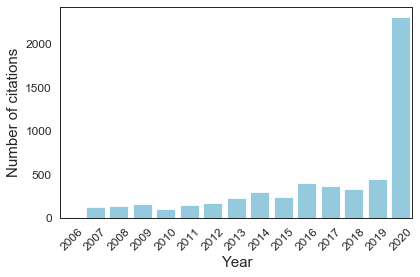

In [113]:
# year posted_on actions histogram

#plt.figure(figsize=(10,5))
b = sns.countplot(x="posted_on_year", data=df_alt_to_wiki, color="skyblue")
b.set_xticklabels(b.get_xticklabels(), rotation=45)
b.set_xlabel("Year",fontsize=15)
b.set_ylabel("Number of citations",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/wiki_postedon_year.pdf")

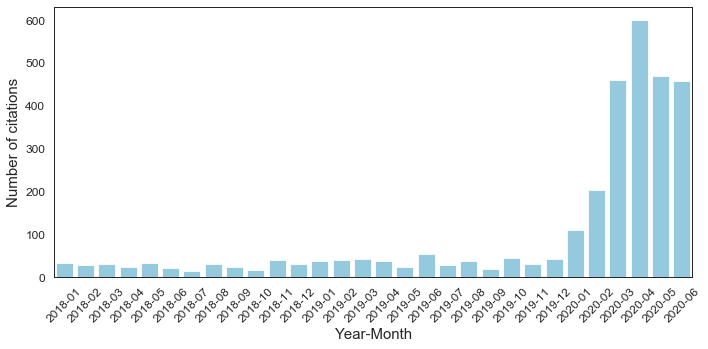

In [135]:
# month-year posted_on actions histogram

since_when = 2018
plt.figure(figsize=(10,5))
b = sns.countplot(x="posted_on_ym", data=df_alt_to_wiki[(df_alt_to_wiki.posted_on_year>=since_when)&(df_alt_to_wiki.posted_on_ym!="2020-07")], order=sorted(df_alt_to_wiki[(df_alt_to_wiki.posted_on_year>=since_when)&(df_alt_to_wiki.posted_on_ym!="2020-07")].posted_on_ym.unique()), color="skyblue")
b.set_xticklabels(b.get_xticklabels(), rotation=45)
b.set_xlabel("Year-Month",fontsize=15)
b.set_ylabel("Number of citations",fontsize=15)
b.tick_params(labelsize=12)
#plt.xlim(("2018-01","2020-06"))
plt.tight_layout()
plt.savefig("figures/wiki_postedon_year_month.pdf")

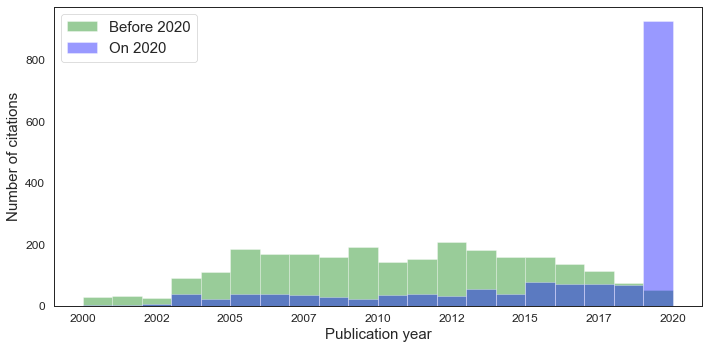

In [115]:
# publication years of articles cited by Wikipedia by posted_on action 
#(i.e., with duplicates for multiple posted_on actions on different Wikipedia pages)

since_when = 2020
from_when = 2000

df_alt_to_wiki_joined_altmetrics = df_alt_to_wiki.merge(df_altmetrics, how="left", left_on="altmetric_id", right_on="altmetric_id")
plt.figure(figsize=(10,5))
#sns.distplot([int(l) for l in df_alt_to_wiki_joined_altmetrics[(df_alt_to_wiki_joined_altmetrics.year>=from_when)].year.to_list()], bins=20, color="skyblue", kde=False, label="All")
sns.distplot([int(l) for l in df_alt_to_wiki_joined_altmetrics[(df_alt_to_wiki_joined_altmetrics.posted_on_year<since_when) & (df_alt_to_wiki_joined_altmetrics.year>=from_when)].year.to_list()], bins=20, color="green", kde=False, label="Before %d"%since_when)
b = sns.distplot([int(l) for l in df_alt_to_wiki_joined_altmetrics[(df_alt_to_wiki_joined_altmetrics.posted_on_year>=since_when) & (df_alt_to_wiki_joined_altmetrics.year>=from_when)].year.to_list()], bins=20, color="blue", kde=False, label="On %d"%since_when)
b.set_xlabel("Publication year",fontsize=15)
b.set_ylabel("Number of citations",fontsize=15)
b.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("figures/wiki_year_postedon.pdf")

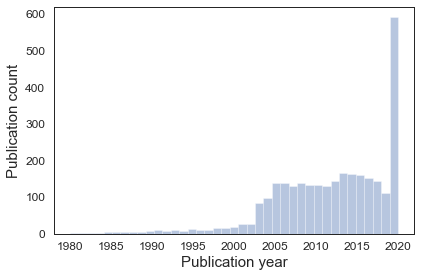

In [116]:
# publication years of articles cited by Wikipedia

#plt.figure(figsize=(10,5))
#sns.distplot(df_meta[df_meta.publication_year>1979].publication_year, color="skyblue", bins=39, label="All", norm_hist=False, kde=False)
b = sns.distplot(df_alt_to_wiki_joined_altmetrics[df_alt_to_wiki_joined_altmetrics.year>1979].groupby("altmetric_id").first().reset_index().year, bins=39, label="In Wikipedia", norm_hist=False, kde=False)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
#b.set_xticklabels(b.get_xticklabels(), rotation=45)
b.set_xlabel("Publication year",fontsize=15)
b.set_ylabel("Publication count",fontsize=15)
b.tick_params(labelsize=12)
#plt.legend(fontsize=15)
plt.tight_layout()
#plt.savefig("figures/wiki_year_both.pdf")
plt.savefig("figures/wiki_year.pdf")

In [129]:
# Fraction of cited papers per year
coverage_by_year = list()
since_when = 2003
for y in range(since_when,2021):
    cov = df_alt_to_wiki_joined_altmetrics[df_alt_to_wiki_joined_altmetrics.year==y].shape[0]/df_meta[df_meta.publication_year==y].shape[0]
    coverage_by_year.append(cov)
    print(y,cov)

2003 0.06833956219967965
2004 0.04782608695652174
2005 0.08129784907036092
2006 0.07147862648913805
2007 0.07318840579710145
2008 0.05421861409104088
2009 0.05313523042054898
2010 0.04479140005119017
2011 0.04286365709074327
2012 0.04892086330935252
2013 0.040428472702142365
2014 0.029791761665906673
2015 0.03323823109843081
2016 0.0284805751417116
2017 0.026099290780141844
2018 0.02062780269058296
2019 0.019018583042973287
2020 0.011607940105776496


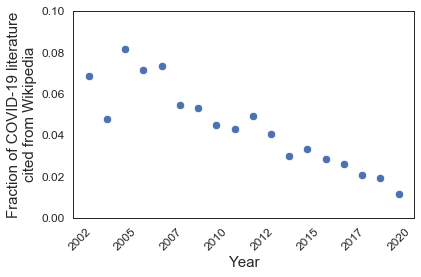

In [120]:
b = sns.scatterplot([y for y in range(since_when,2021)],coverage_by_year,s=70)
b.set_xlabel("Year",fontsize=15)
b.set_ylabel("Fraction of COVID-19 literature\ncited from Wikipedia",fontsize=15)
b.set_xticklabels(range(since_when,2021),rotation=45)
b.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.ylim((0,0.1))
plt.tight_layout()
plt.savefig("figures/wiki_fraction_year.pdf")

In [74]:
# most Wiki cited papers

In [75]:
df_top_cited = df_alt_to_wiki.groupby("doi").agg('count').sort_values('wikipedia_id',ascending=False)[:20]
df_top_cited.reset_index(inplace=True)

In [144]:
df_top_cited[["doi",'wikipedia_id']].merge(df_joined, how="left", right_on="doi", left_on="doi")[["doi",
    "wikipedia_id","title","publication_year","journal","times_cited"]]

,doi,wikipedia_id,title,publication_year,journal,times_cited
0,10.3390/info11050263,67,Modeling Popularity and Reliability of Sources...,2020.0,Information,1.0
1,10.1007/s00705-012-1299-6,18,Ratification vote on taxonomic proposals to th...,2012.0,Arch Virol,210.0
2,10.1007/978-1-4939-2438-7_1,15,Coronaviruses: An Overview of Their Replicatio...,2015.0,Methods in Molecular Biology,395.0
3,10.3390/v2081803,15,Coronavirus Genomics and Bioinformatics Analysis,2010.0,Viruses,143.0
4,10.1016/s0140-6736(20)30183-5,13,Clinical features of patients infected with 20...,2020.0,The Lancet,5508.0
5,10.3390/su12104295,12,An Integrated Planning Framework for Sustainab...,2020.0,Sustainability,1.0
6,10.1002/med.20081,12,The regulation of HIV‐1 transcription: Molecul...,2006.0,Med Res Rev,93.0
7,10.1056/nejmoa2001316,11,"Early Transmission Dynamics in Wuhan, China, o...",2020.0,New England Journal of Medicine,2399.0
8,10.3390/v11020174,11,Global Epidemiology of Bat Coronaviruses,2019.0,Viruses,39.0
9,10.1056/nejmoa2001191,11,First Case of 2019 Novel Coronavirus in the Un...,2020.0,New England Journal of Medicine,1127.0


In [138]:
#print(df_top_cited[["doi",'wikipedia_id']].merge(df_joined, how="left", right_on="doi", left_on="doi")[[
#    "wikipedia_id","doi","title","publication_year","journal","times_cited"]].to_latex(index=False,bold_rows=True,caption="",label=""))

In [139]:
# most citing Wiki articles

In [140]:
df_top_citing = df_alt_to_wiki.groupby("wikipedia_id").agg('count').sort_values('doi',ascending=False)[:20]
df_top_citing.reset_index(inplace=True)

In [141]:
df_top_citing[["altmetric_id",'wikipedia_id']].merge(df_wikipedia, how="left", right_on="wikipedia_id", left_on="wikipedia_id")[["altmetric_id",
    "wikipedia_id","title","page_url","lang","summary"]]

,altmetric_id,wikipedia_id,title,page_url,lang,summary
0,62,201983,Coronavirus,http://en.wikipedia.org/?curid=201983,en,Coronaviruses are a group of related viruses t...
1,59,62786585,Severe acute respiratory syndrome coronavirus 2,http://en.wikipedia.org/?curid=62786585,en,Severe acute respiratory syndrome coronavirus ...
2,53,62750956,2019–20 Wuhan coronavirus outbreak,http://en.wikipedia.org/?curid=62750956,en,"A new coronavirus, designated 2019-nCoV, was i..."
3,49,63030231,Coronavirus disease 2019,http://en.wikipedia.org/?curid=63030231,en,"Common symptoms include fever, cough, fatigue,..."
4,39,63676463,2019–20 coronavirus pandemic/sandbox,http://en.wikipedia.org/?curid=63676463,en,The 2019–20 coronavirus pandemic is an ongoing...
5,36,63430824,COVID-19 drug repurposing research,http://en.wikipedia.org/?curid=63430824,en,"During the pandemic, several existing antivira..."
6,33,63895130,Paediatric multisystem inflammatory syndrome,http://en.wikipedia.org/?curid=63895130,en,Paediatric multisystem inflammatory syndrome (...
7,32,211547,Severe acute respiratory syndrome-related coro...,http://en.wikipedia.org/?curid=211547,en,Severe acute respiratory syndrome-related coro...
8,31,63319438,COVID-19 vaccine,http://en.wikipedia.org/?curid=63319438,en,A COVID-19 vaccine is a hypothetical vaccine a...
9,30,63435931,COVID-19 drug development,http://en.wikipedia.org/?curid=63435931,en,COVID‑19 drug development is the research proc...


In [143]:
#print(df_top_citing[["altmetric_id",'wikipedia_id']].merge(df_wikipedia, how="left", right_on="wikipedia_id", left_on="wikipedia_id")[["altmetric_id",
#    "wikipedia_id","title","lang"]].to_latex(index=False,bold_rows=True))

#### Finish merges and save

In [80]:
df_altmetrics.pmid = pd.to_numeric(df_altmetrics.pmid)

In [81]:
## join with Altmetrics

df_tmp_a = df_altmetrics[pd.isnull(df_altmetrics.doi)] 
df_tmp_j = df_joined[pd.isnull(df_joined.doi)] 
df_joined_all = df_joined[pd.notnull(df_joined.doi)].merge(df_altmetrics[pd.notnull(df_altmetrics.doi)], suffixes=('','_y'), how="left", left_on="doi", right_on="doi")
df_joined_all.drop(columns=['pmid_y', 'year_y', 'title_y'],inplace=True)

In [82]:
df_joined_tt = df_tmp_j.merge(df_tmp_a, how="left", suffixes=('','_y'), left_on="pmid", right_on="pmid")
df_joined_tt.drop(columns=["doi_y", 'year_y', 'title_y'],inplace=True)
df_joined_all = pd.concat([df_joined_all,df_joined_tt])
df_joined_all.drop_duplicates("pub_id",inplace=True)
df_joined_all.reset_index(inplace=True,drop=True)

In [83]:
df_joined_all.shape

(141224, 42)

In [84]:
df_joined_all.columns

Index(['pub_id', 'title', 'abstract', 'publication_year', 'publication_month',
       'journal', 'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'arxiv_id', 'timestamp', 'lang', 'id', 'altmetric_id',
       'year', 'month', 'publication_date', 'publication_type', 'issn',
       'times_cited', 'relative_citation_ratio', 'for_top', 'for_bottom',
       'altmetric_id_y', 'counts_mendeley', 'counts_news', 'counts_blogs',
       'counts_facebook', 'counts_policy', 'counts_wikipedia',
       'counts_twitter_count', 'counts_twitter_unique', 'counts_total',
       'altmetric_score', 'member_of_the_public', 'researcher', 'practitioner',
       'science_communicator'],
      dtype='object')

In [85]:
df_joined_all.drop(columns=["dimensions_id","year","month","altmetric_id","timestamp"], inplace=True)
df_joined_all.rename(columns={"id":"dimensions_id","altmetric_id_y":"altmetric_id","counts_twitter_count":"counts_twitter"}, inplace=True)

In [86]:
df_joined_all[df_joined_all.pub_id==29534]

,pub_id,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,...,counts_policy,counts_wikipedia,counts_twitter,counts_twitter_unique,counts_total,altmetric_score,member_of_the_public,researcher,practitioner,science_communicator
28533,29534,Chapter 11 Detection of Analytes on Arrays/Mic...,Publisher Summary Microarrays/arrays/DNA chips...,2011.0,12.0,Handbook of Biosensors and Biosensor Kinetics,NaN,NaN,NaN,10.1016/b978-0-444-53262-6.00011-5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
df_joined_all["in_wikipedia"] = df_joined_all["counts_wikipedia"]>0

In [88]:
df_joined_all.shape

(141224, 38)

In [89]:
df_posted_on_first = df_alt_to_wiki[["altmetric_id","posted_on_year"]].groupby("altmetric_id").agg(min).reset_index()

In [90]:
df_joined_all = df_joined_all.merge(df_posted_on_first, how="left", left_on="altmetric_id", right_on="altmetric_id")

In [91]:
df_joined_all[df_joined_all.in_wikipedia==True].shape[0]/df_meta.shape[0]

0.019190070710088637

In [92]:
# save to disk

df_joined_all.to_csv("data/df_joined_all.csv", compression="gzip", index=False)
df_meta.to_csv("data/df_meta.csv", compression="gzip", index=False)

### Analysis of time to be cited from publication

In [93]:
# average time from publication to citations

df_posted_on_first = df_alt_to_wiki[["altmetric_id","posted_on_year","posted_on_month"]].groupby("altmetric_id").agg(min).reset_index()

In [94]:
df_posted_on_first = df_posted_on_first.merge(df_joined_all, how="left", right_on="altmetric_id", left_on="altmetric_id")

In [95]:
df_posted_on_first["time_from_pub_to_wiki"] = ((df_posted_on_first["posted_on_year_x"]*12)+df_posted_on_first["posted_on_month"]) - ((df_posted_on_first["publication_year"]*12)+df_posted_on_first["publication_month"])

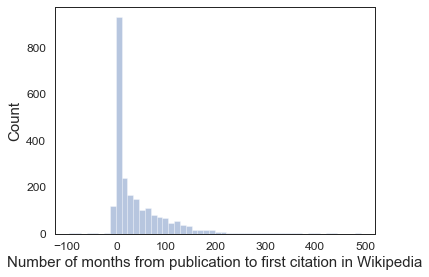

In [96]:
sns.distplot(df_posted_on_first["time_from_pub_to_wiki"], norm_hist=False, kde=False)
plt.xlabel("Number of months from publication to first citation in Wikipedia",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb1_time_from_pub_to_wiki_hist.pdf")

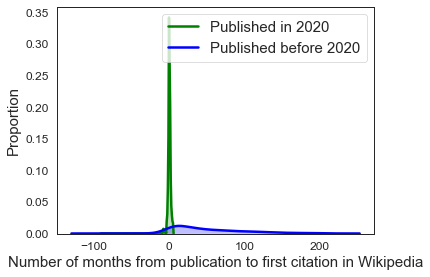

In [97]:
sns.distplot(df_posted_on_first[df_posted_on_first.publication_year==2020]["time_from_pub_to_wiki"], color="green", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Published in 2020")
sns.distplot(df_posted_on_first[(df_posted_on_first.publication_year<2020) & (df_posted_on_first.publication_year>1999)]["time_from_pub_to_wiki"], color="blue", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Published before 2020")
plt.legend(fontsize=15)
plt.xlabel("Number of months from publication to first citation in Wikipedia",fontsize=15)
plt.ylabel("Proportion",fontsize=15)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb1_time_from_pub_to_wiki_hist_normed.pdf")

In [98]:
#df_posted_on_first[["time_from_pub_to_wiki","posted_on_year_x","posted_on_month","publication_year","publication_month","in_wikipedia"]]

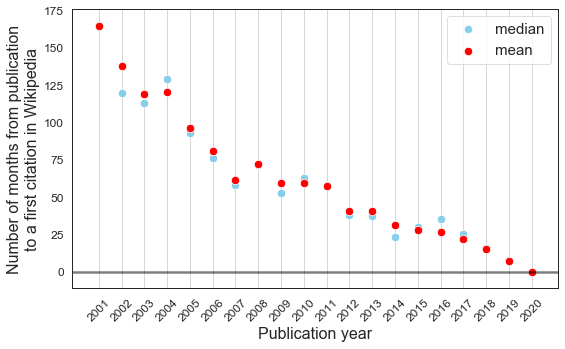

In [127]:
from_year = 2001
until_year = 2020
posted_on_limit = 2020

plt.figure(figsize=(8,5))
sns.scatterplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.median).reset_index(), s=70, color="skyblue", label="median")
b = sns.scatterplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.mean).reset_index(), s=70, color="red", label="mean")
b.set_xticklabels(b.get_xticklabels(), rotation=45)
plt.legend(fontsize=15)
plt.ylabel("Number of months from publication\nto a first citation in Wikipedia",fontsize=16)
plt.xlabel("Publication year",fontsize=16)
plt.xticks(range(from_year,until_year+1))
plt.tick_params(labelsize=12)
plt.axhline(y=0.0, color='black', linestyle='-', alpha=0.5)
ax = plt.gca()
ax.grid(True, axis='x')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
#plt.title("Number of months elapsed from publication to the first Wikipedia citation", fontsize=17)
plt.tight_layout()
plt.savefig("figures/nb1_time_from_pub_to_wiki_avg_per_year.pdf")

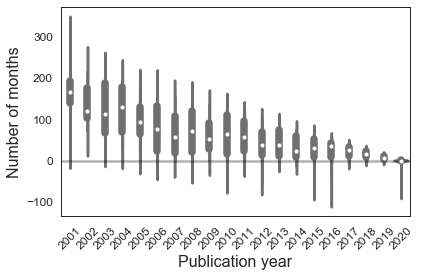

In [124]:
from_year = 2001
until_year = 2020
posted_on_limit = 2020

#fig, ax = plt.subplots(figsize=(8,5))
#fig, ax = plt.subplots()
#sns.scatterplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.median).reset_index(), s=70, color="skyblue", label="median")
#sns.violinplot(x="day", y="total_bill", hue="sex",
#                    data=tips, palette="Set2", split=True,
#                    scale="count", inner="stick")
#a = sns.scatterplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.mean).reset_index(), s=70, color="red", ax=ax)
#ax2 = ax.twinx()
#b = sns.catplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]], color="gray", s=3)
b = sns.violinplot(x="publication_year", y="time_from_pub_to_wiki", data=df_posted_on_first[(df_posted_on_first.publication_year>=from_year)&(df_posted_on_first.publication_year<=until_year)&(df_posted_on_first.posted_on_year_x<=posted_on_limit)][["publication_year","time_from_pub_to_wiki"]], color="skyblue", s=3)
b.set_xticklabels(range(from_year,until_year+1),rotation=45)
plt.ylabel("Number of months",fontsize=16)
plt.xlabel("Publication year",fontsize=16)
plt.tick_params(labelsize=12)
plt.axhline(y=0.0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig("figures/nb1_time_from_pub_to_wiki_avg_per_year_violin.pdf")

In [104]:
df_meta[df_meta.publication_year==2020].shape

(72795, 16)

In [105]:
df_posted_on_first[["publication_year","time_from_pub_to_wiki"]].groupby("publication_year").agg(np.mean).reset_index()

,publication_year,time_from_pub_to_wiki
0,1968.0,NaN
1,1970.0,NaN
2,1978.0,422.000000
3,1979.0,491.000000
4,1982.0,316.000000
5,1983.0,435.000000
6,1984.0,294.000000
7,1985.0,358.000000
8,1986.0,400.000000
9,1987.0,310.000000


In [106]:
df_posted_on_first[(df_posted_on_first.publication_year==2020)&(df_posted_on_first.time_from_pub_to_wiki < 0)]

,altmetric_id,posted_on_year_x,posted_on_month,pub_id,title,abstract,publication_year,publication_month,journal,volume,...,counts_twitter_unique,counts_total,altmetric_score,member_of_the_public,researcher,practitioner,science_communicator,in_wikipedia,posted_on_year_y,time_from_pub_to_wiki
1203,3397958,2012,11,91792.0,DHP Framework: Digital Health Passports Using ...,"In order to contain the COVID-19 pandemic, sev...",2020.0,5.0,NaN,NaN,...,0.0,1.0,3.000,0.0,0.0,0.0,0.0,True,2012.0,-90.0
2746,74005599,2020,1,76827.0,"Pneumonia of Unknown Etiology in Wuhan, China:...",There is currently an outbreak of pneumonia of...,2020.0,3.0,Journal of Travel Medicine,27,...,535.0,623.0,527.360,435.0,55.0,36.0,9.0,True,2020.0,-2.0
2747,74006487,2020,2,32956.0,Comparison of broad-spectrum antiviral activit...,"Rocaglates, a class of natural compounds isola...",2020.0,3.0,Antiviral Research,175,...,10.0,22.0,69.750,8.0,2.0,0.0,0.0,True,2020.0,-1.0
2771,74464078,2020,1,57176.0,Clinical features of patients infected with 20...,BACKGROUND: A recent cluster of pneumonia case...,2020.0,2.0,The Lancet,395,...,15126.0,20644.0,14257.298,13709.0,688.0,511.0,211.0,True,2020.0,-1.0
2772,74464103,2020,1,57170.0,A familial cluster of pneumonia associated wit...,BACKGROUND: An ongoing outbreak of pneumonia a...,2020.0,2.0,The Lancet,395,...,4483.0,5339.0,4632.252,4073.0,216.0,147.0,45.0,True,2020.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,82704653,2020,5,66352.0,Tail risk of contagious diseases,The COVID-19 pandemic has been a sobering remi...,2020.0,6.0,Nature Physics,16,...,698.0,788.0,508.662,563.0,106.0,17.0,12.0,True,2020.0,-1.0
3554,82970555,2020,5,70487.0,Studies on the mechanism of general anesthesia,Inhaled anesthetics are a chemically diverse c...,2020.0,6.0,Proceedings of the National Academy of Science...,117,...,1335.0,1435.0,737.350,1252.0,55.0,22.0,6.0,True,2020.0,-1.0
3557,83016981,2020,6,111617.0,Population vulnerability to COVID-19 in Europe...,Background: Evidence has emerged showing that ...,2020.0,12.0,Archives of Public Health,78,...,34.0,54.0,57.850,16.0,8.0,9.0,1.0,True,2020.0,-6.0
3572,83355890,2020,6,111392.0,Acute myocarditis and multisystem inflammatory...,BACKGROUND: A recent increase in children admi...,2020.0,12.0,Annals of Intensive Care,10,...,26.0,29.0,17.350,10.0,4.0,11.0,1.0,True,2020.0,-6.0
